# We’ll follow the general machine learning workflow step-by-step:

1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model
6. Evaluate the best model on the testing set
7. Interpret the model results
8. Draw conclusions and document work

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

Load data as a Pandas DataFrame (DF):

In [7]:
filepath = r"C:\Users\Samuel.Harrison.CTR\Downloads\nyc_benchmarking_disclosure_data_reported_in_2017.csv" 
data = pd.read_csv(filepath, encoding='latin1')

Display top of DF

In [8]:
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Unnamed: 54
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,51550675.1,Not Available,Not Available,38139374.2,11082770.5,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,5/1/17 5:32 PM,No,In Compliance,NaN
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,19624847.2,Not Available,Not Available,Not Available,-391414802.6,933073441,9330734.4,332365924,96261312.1,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,4/27/17 11:23 AM,No,In Compliance,NaN
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,4/27/17 11:23 AM,No,In Compliance,NaN
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1305748,Not Available,Not Available,Not Available,Not Available,1971,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available

View the column data types and non-missing values

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 55 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11746 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

Replace all occurrences of Not Available with numpy not a number

In [10]:
data = data.replace({'Not Available': np.nan})

Iterate through the columns. Select columns that should be numeric. Convert the data type to float.

In [11]:
for col in list(data.columns):  
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in col or 'therms' in col or 'gal' in col or 'Score' in col):
        data[col] = data[col].astype(float)

Missing Data and Outliers

In addition to incorrect datatypes, another common problem when dealing with real-world data is missing values. These can arise for many reasons and have to be either filled in or removed before we train a machine learning model. First, let’s get a sense of how many missing values are in each column

In [12]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
missing_values_table(data)

Your selected dataframe has 55 columns.
There are 40 columns that have missing values.


,Missing Values,% of Total Values
Unnamed: 54,11746,100.0
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type,10262,87.4
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0


In [14]:
# Get the columns with > 50% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 55 columns.
There are 40 columns that have missing values.
We will remove 12 columns.


In [15]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we make plots and calculate statistics in order to explore our data. The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine.

To begin the EDA, we will focus on a single variable, the Energy Star Score, because this is the target for our machine learning models. We can rename the column to score for simplicity and then start exploring this value.

Single Variable Plots

A single variable (called univariate) plot shows the distribution of a single variable such as in a histogram

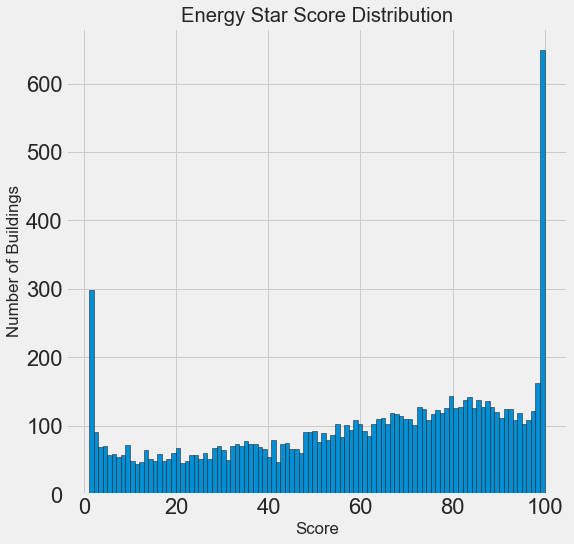

In [16]:
figsize(8, 8)

# Rename the score 
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('Energy Star Score Distribution');

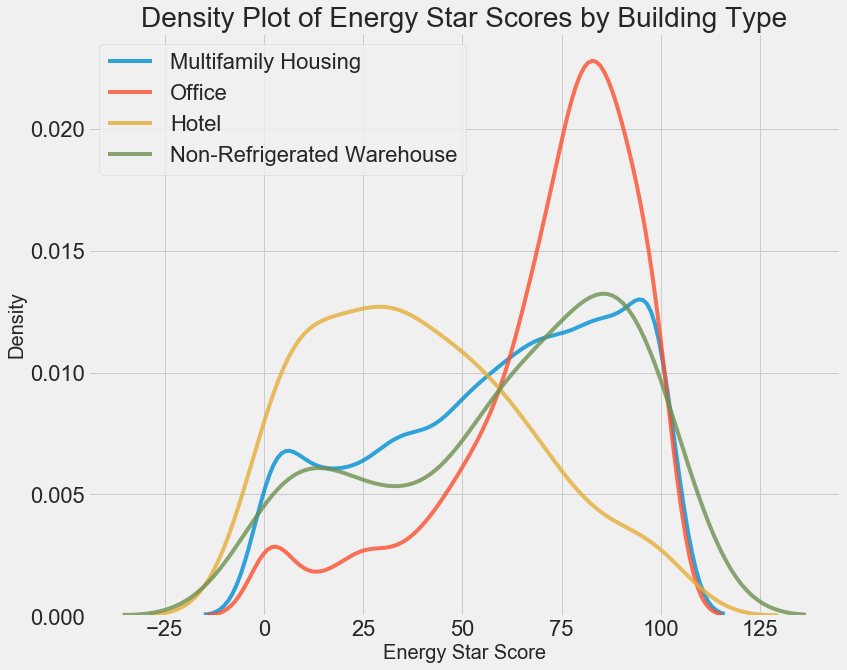

In [18]:
# Create a list of buildings with more than 100 measurements
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

# Plot of distribution of scores for building categories
figsize(12, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

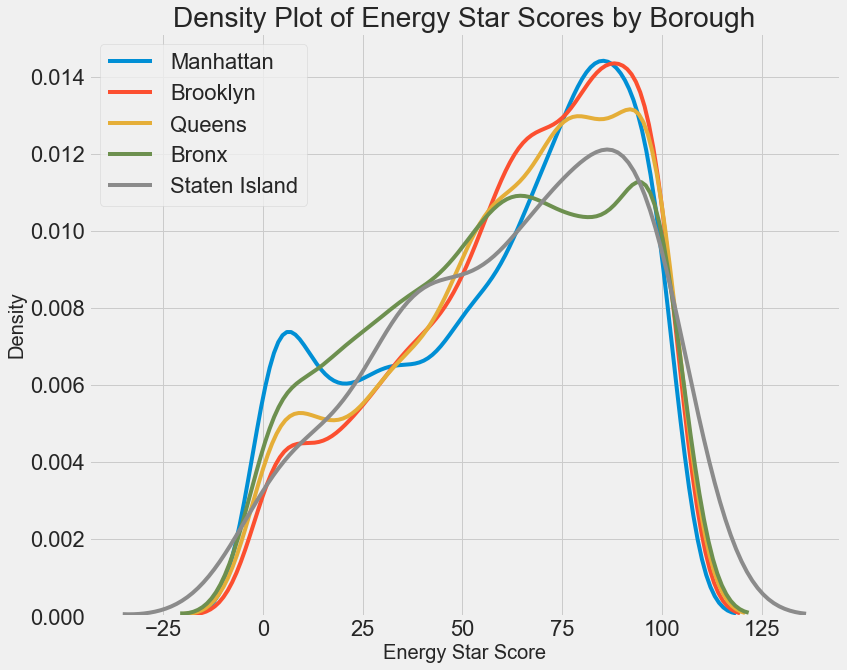

In [20]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

# Plot of distribution of scores for boroughs
figsize(12, 10)

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

In [23]:
#Find all correlations and sort 
correlations_data = data.corr()['score'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Year Built                                                -0.118181
Weather Normalized Site Electricity Intensity (kWh/ft²)   -0.067762
Electricity Use - Grid Purchase (kBtu)                    -0.066330
Weather Normalized Site Electricity (kWh)                 -0.065789
Total GHG Emissions (Metric Tons CO2e)                    -0.047934
Property Id                                               -0.047020
Source EUI (kBtu/ft²)                                     -0.042873
Weather Normalized Source EUI (kBtu/ft²)                  -0.040913
Indirect GHG Emissions (Metric Tons CO2e)                 -0.040326
Site EUI (kBtu/ft²)                                       -0.036123
Weather Normalized Site EUI (kBtu/ft²)                    -0.035227
Occupancy                                                 -0.031116
Direct GHG Emissions (Metric Tons CO2e)                   -0.026355
Weather Normalized Site Natural Gas Use (therms)          -0.026215
Natural Gas Use (kBtu)                          